# Heat Flux Notebook

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
import gsw

In [2]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [3]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [4]:
numeric_vars = [var for var in ds if np.issubdtype(ds[var].dtype, np.number)]
ds = ds[numeric_vars]

In [5]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [6]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)

In [7]:
ds_binned.to_netcdf('/swot/SUM05/amf2288/sync-boxes/globe_binned_3_z.nc')

In [8]:
%%time
ds_binned = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/globe_binned_3_z.nc', chunks={'z_c':20}).load()

CPU times: user 823 ms, sys: 548 ms, total: 1.37 s
Wall time: 1.28 s


In [9]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc')
K_rho = ds_diff.K
K_rho = K_rho.interp(z_c=ds_binned.z_c)
e = ds_diff.e.interp(z_c=ds_binned.z_c)

In [10]:
dCT_dz = ds_binned.CT.differentiate('z_c')
dCT_dx = ds_binned.CT.differentiate('lon_c')
dCT_dy = ds_binned.CT.differentiate('lat_c')

In [11]:
uT = (K_rho*dCT_dz**2)/dCT_dx
vT = (K_rho*dCT_dz**2)/dCT_dy

In [12]:
depth = 1000

In [32]:
lon = -25

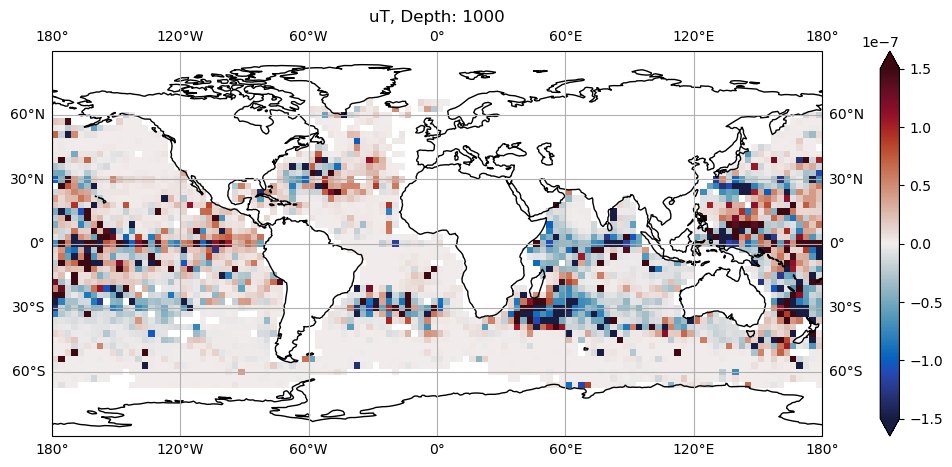

In [30]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
uT.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-1.5e-7, vmax=1.5e-7)
ax.set_title('uT, Depth: {}'.format(depth));

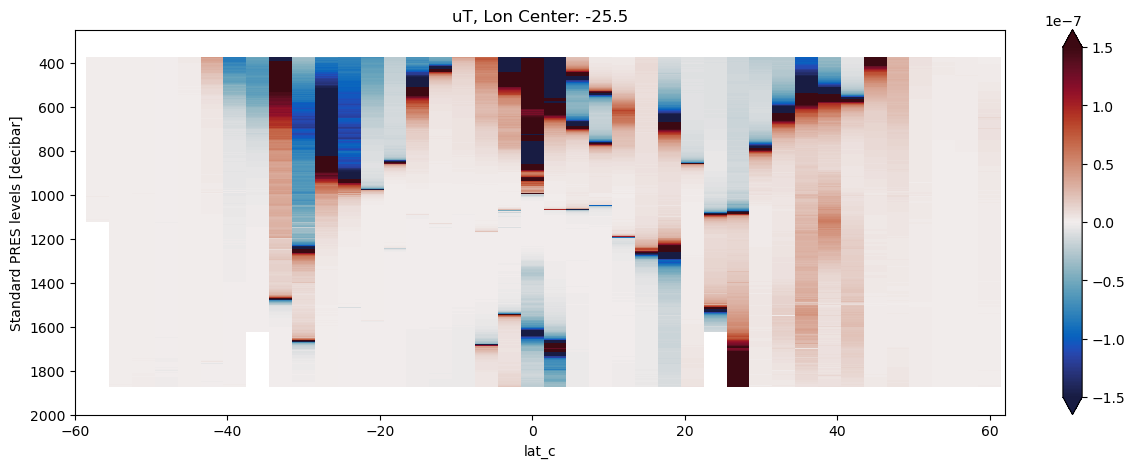

In [39]:
fig=plt.figure(figsize=(15,5))
uT.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmo.balance, vmin=-1.5e-7, vmax=1.5e-7)
plt.gca().invert_yaxis()
plt.xlim(-60,62)
plt.ylim(2000,250)
plt.title('uT, Lon Center: {}'.format(uT.sel(lon_c=lon, method='nearest').lon_c.values));

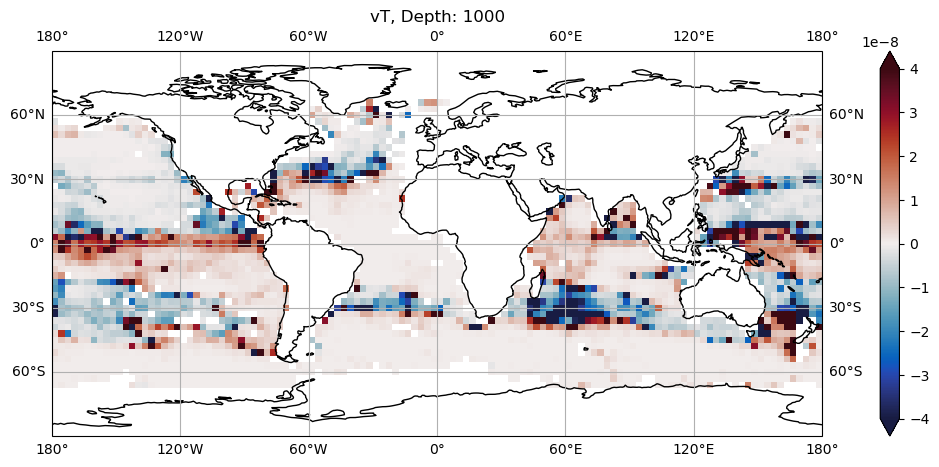

In [18]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
vT.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
ax.set_title('vT, Depth: {}'.format(depth));

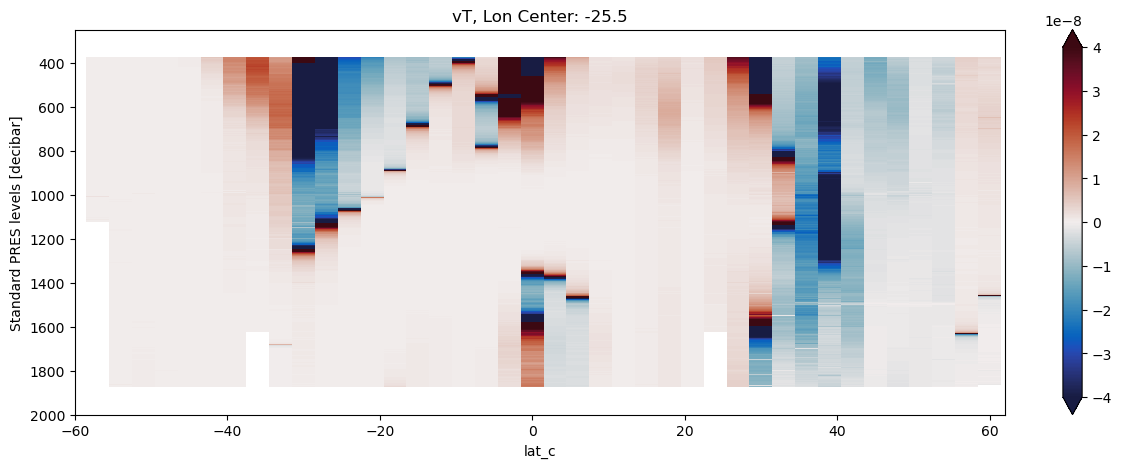

In [40]:
fig=plt.figure(figsize=(15,5))
vT.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
plt.gca().invert_yaxis()
plt.xlim(-60,62)
plt.ylim(2000,250)
plt.title('vT, Lon Center: {}'.format(uT.sel(lon_c=lon, method='nearest').lon_c.values));